In [1]:
!git clone https://github.com/tavishgandhi/Self-Drive-Car-Track-Data.git

Cloning into 'Self-Drive-Car-Track-Data'...
remote: Enumerating objects: 12168, done.
remote: Counting objects: 100% (12168/12168), done.
remote: Compressing objects: 100% (12167/12167), done.
remote: Total 12168 (delta 0), reused 12165 (delta 0), pack-reused 0
Receiving objects: 100% (12168/12168), 156.98 MiB | 40.00 MiB/s, done.
Checking out files: 100% (12161/12161), done.


In [3]:
!ls Self-Drive-Car-Track-Data


driving_log.csv  IMG  README.md


In [5]:
!pip install imgaug

In [4]:
import os
import numpy as np
# import eventlet
# import socketio
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from imgaug import augmenters as iaa
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import ntpath # Used to contain whole path of a certain thing,which then can be split
import random
import flask


Using TensorFlow backend.


In [8]:
datadir = 'Self-Drive-Car-Track-Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)# It removes the '....' in each row and display full path.
data.head()


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [9]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


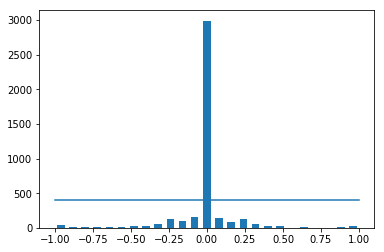

In [10]:
#Now we should plot the steering angles against the times it was used in 
#training model

num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) *0.5
print(bins)
plt.bar(center, hist, width = 0.05)

# We see that the data is skewed towards center so we make
# sure that it counts sample only till 200
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


Total Data :  4053
removed :  2590
 remaining :  1463


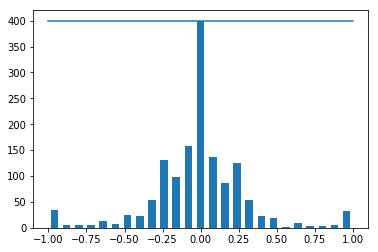

In [11]:
print("Total Data : ", len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_) 

print('removed : ' , len(remove_list))  
data.drop(data.index[remove_list], inplace = True)
print(" remaining : ", len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)

# We see that the data is skewed towards center so we make
# sure that it counts sample only till 200
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [0]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering) 
  return image_paths, steerings


image_paths , steerings = load_img_steering(datadir + '/IMG' , data)


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training Samples : {}\nValid Samples : {}'.format(len(X_train), len(X_valid)))

Training Samples : 1170
Valid Samples : 293


Text(0.5, 1.0, 'validation Set')

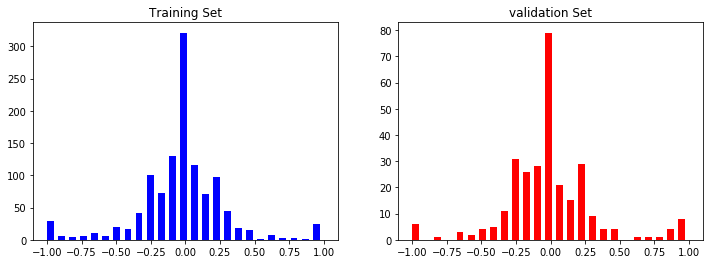

In [14]:
fig , axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(y_train, bins = num_bins, width = 0.05, color ='blue')
axs[0].set_title("Training Set")

axs[1].hist(y_valid, bins = num_bins, width = 0.05, color ='red')
axs[1].set_title("validation Set")


In [0]:
# Zooming the images of our datasets 
# Data Augmentation

def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # Here this function allows a 30% zoom in image.
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

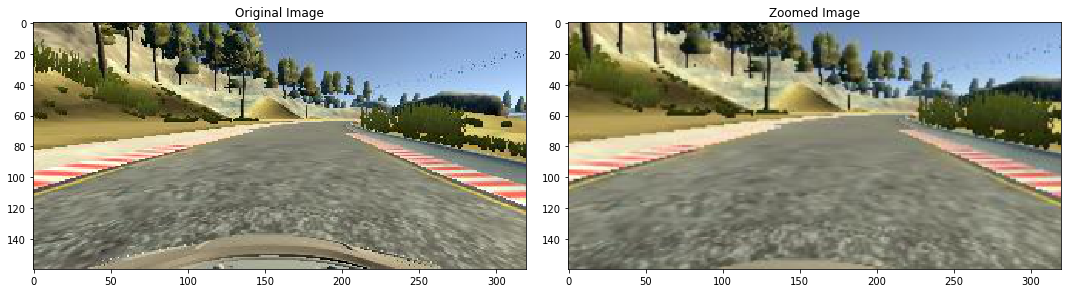

In [16]:
# Visualizing the zoom augmentation

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')
              

In [0]:
# This data augmentation technique shift the image or translate the image
# a bit horizontal and vertical.

def pan(image):
    pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'panned Image')

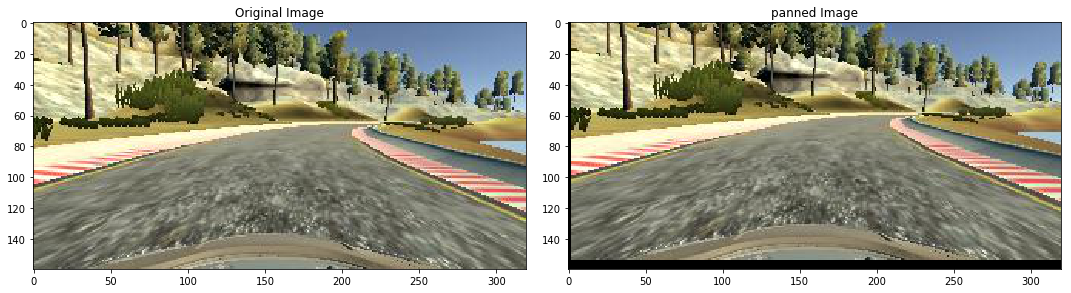

In [18]:
# Visualizing the translational augmentation


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('panned Image')

In [0]:
# This is a data Augmentation technique where we change image brightness
# by multiplying pixel intensities with a fixed number.
# Thus any pixel with intensity less than one will become darker.

def img_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) # randomly choose between 0. and 1.2
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

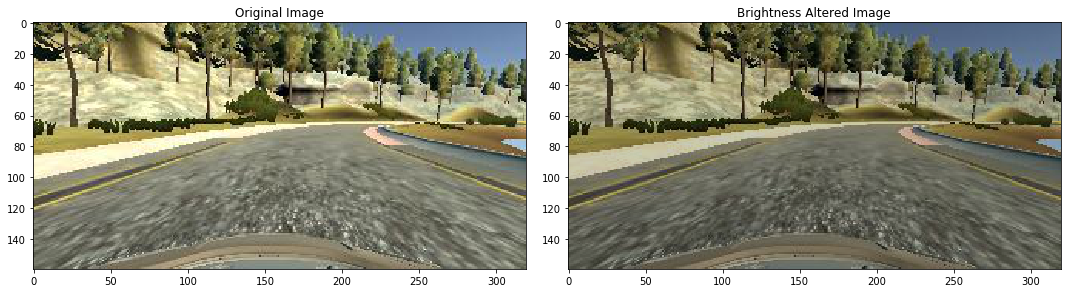

In [20]:
# Visualizing the brighntness data augmentation

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [0]:
# This is data augmentation technique to flip the image

def image_flip(image, steering_angle):
  image = cv2.flip(image, 1) # 1 means horizontal flip, 0 means vertical flip
  steering_angle = -steering_angle # because image is flipped, we need to flip the steering angle too.
  return image, steering_angle
  

Text(0.5, 1.0, 'Flipped ImageSteering angle-0.25')

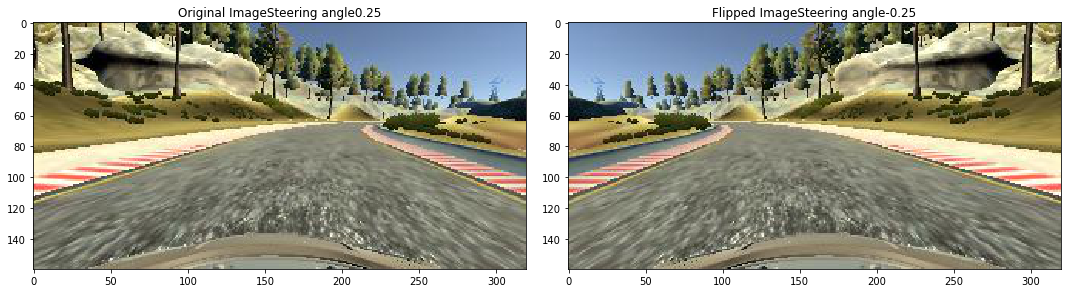

In [22]:
# Visualizing the Flip data augmentation

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = image_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image' + 'Steering angle' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image' + 'Steering angle' + str(flipped_steering_angle))

In [0]:
# We don't want to apply our every data augmentation to every image,
# so we will only apply it to 50% of our data.

def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image, steering_angle = image_flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = img_brightness(image)
  
  return image, steering_angle

In [0]:
# Visualizing our every data augmentation technique.

# ncol = 2
# nrow = 10
# fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
# fig.tight_layout()

# for i in range(10):
#   randnum = random.randint(0, len(image_paths) - 1)
#   random_image = image_paths[randnum]
#   random_steering = steerings[randnum]
  
#   original_image = mpimg.imread(random_image)
#   augmented_image, steering = random_augment(random_image, random_steering)
  
#   axs[i][0].imshow(original_image)
#   axs[i][0].set_title("Original Image")
  
#   axs[i][1].imshow(augmented_image)
#   axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocessing(img):
#   img = mpimg.imread(img) # commented out for batch size as image there will alreay be read
  img = img[60:135 , :, :] #Our image has got trees and car hood which is uneccessary,also an image is array of height width and depth,so we can crop image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3) , 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [27]:
#This column will show error as we have commented the read image portion, uncomment to remove erroe 
#Commented because while evaluating model, we already pass read image in function 

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessing(image)

fig, axs = plt.subplots(1, 2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


TypeError: ignored








When we Generate data which is augmented, it is better to use batches for that and create new data only when needed rather than storing all the additional data in memory.

Since fit() requires the entire dataset  as numpy array in memory, which is why for larger datasets, we make use of fit_generator(), to generate augmented images on the fly when needed, and this is done in batches.


Small Datsets                                  Large Datasets

fit()                                                    fit_generator()
predict()                                   predict_generator() 

In [0]:
# The istraining argument is boolean where True means Training set and false
# is validation test. We dont want to include our augmented data in validation
# batch set.

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
        
      im = img_preprocessing(im)
      
      batch_img.append(im)
      batch_steering.append(steering)
    
    yield (np.asarray(batch_img), np.asarray(batch_steering))
  

Text(0.5, 1.0, 'Validation Image')

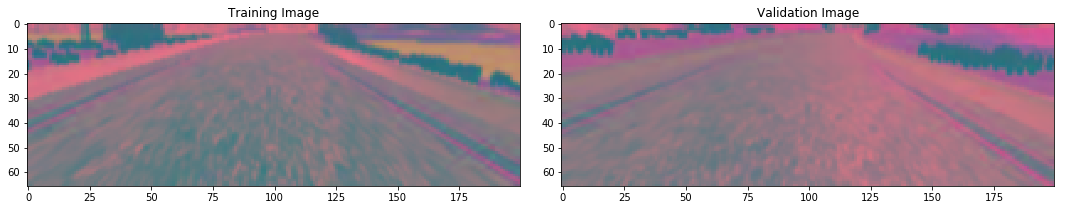

In [29]:
X_train_gen , y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_val_gen , y_val_gen = next(batch_generator(X_train, y_train, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(X_val_gen[0])
axs[1].set_title('Validation Image')




In [32]:
# X_train = np.array(list(map(img_preprocessing, X_train)))
# X_valid = np.array(list(map(img_preprocessing, X_valid)))

TypeError: ignored

TypeError: ignored

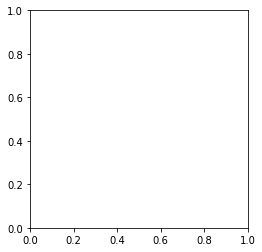

In [31]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample = (2,2), input_shape = (66,200,3),activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample = (2,2), activation= 'elu'))
  model.add(Convolution2D(48, 5, 5, subsample = (2,2), activation= 'elu'))
  model.add(Convolution2D(64, 3, 3, activation= 'elu'))
  model.add(Convolution2D(64, 3, 3, activation= 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
 
  
  model.add(Dense(10, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(1))
  optimizer = Adam(lr= 1e-4)
  model.compile(loss = 'mse', optimizer = optimizer)
  return model

In [34]:
model = nvidia_model()
print(model.summary())

W0712 07:49:25.336017 139724512671616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
W0712 07:49:25.375539 139724512671616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 07:49:25.387925 139724512671616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [35]:
h = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                        steps_per_epoch = 300,
                        epochs = 10, 
                        validation_data = batch_generator(X_valid, y_valid, 100, 0),
                        validation_steps=200,
                        verbose = 1,
                        shuffle = 1)

# Here this model will predict a high loss in validation set and 
# less in training cause we added too much dropout layer to prevent 
# overfitting, since data is much larger here we can remove some dropout
# layers from model.


W0712 07:49:28.426293 139724512671616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0712 07:49:28.786610 139724512671616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/10
300/300 [==============================] - 140s 467ms/step - loss: 0.0776 - val_loss: 0.0562
Epoch 2/10
300/300 [==============================] - 129s 431ms/step - loss: 0.0609 - val_loss: 0.0580
Epoch 3/10
300/300 [==============================] - 130s 434ms/step - loss: 0.0583 - val_loss: 0.0597
Epoch 4/10
300/300 [==============================] - 128s 428ms/step - loss: 0.0517 - val_loss: 0.0507
Epoch 5/10
300/300 [==============================] - 128s 425ms/step - loss: 0.0477 - val_loss: 0.0429
Epoch 6/10
300/300 [==============================] - 129s 430ms/step - loss: 0.0438 - val_loss: 0.0443
Epoch 7/10
300/300 [==============================] - 128s 427ms/step - loss: 0.0419 - val_loss: 0.0378
Epoch 8/10
300/300 [==============================] - 128s 427ms/step - loss: 0.0399 - val_loss: 0.0386
Epoch 9/10
300/300 [==============================] - 127s 422ms/step - loss: 0.0381 - val_loss: 0.0380
Epoch 10/10
300/300 [==============================] - 127s 422m

Text(0.5, 1.0, 'Loss')

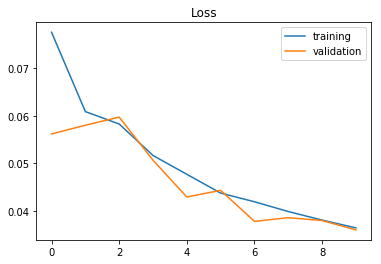

In [36]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')


Text(0.5, 1.0, 'Loss')

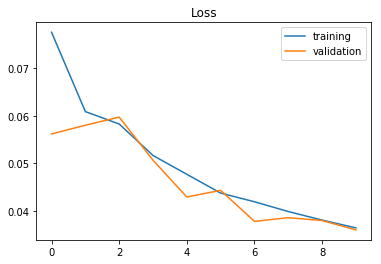

In [37]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')

In [0]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')